# Agentic RAG with two retriever and query rewrite 

In [53]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain.tools import tool
from langchain_classic.prompts import PromptTemplate
from langchain_core.tools.retriever import create_retriever_tool
from pydantic import BaseModel,Field
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from typing import TypedDict, Literal, Annotated, Sequence
from langchain.agents import create_agent
from langgraph.graph.message import add_messages, BaseMessage
from IPython.display import Image, display
from langchain_groq import ChatGroq
from typing import List
from langgraph.prebuilt import tools_condition,ToolNode
from dotenv import load_dotenv
from langchain_classic import hub
import os
load_dotenv()

True

In [90]:
# perfume website
urls = ["https://roozaneh.net/fashion-world/other/%D9%81%D9%88%D8%A7%DB%8C%D8%AF-%D9%88-%D9%85%D8%B9%D8%A7%DB%8C%D8%A8-%D8%A7%D8%B3%D8%AA%D9%81%D8%A7%D8%AF%D9%87-%D8%A7%D8%B2-%D8%B9%D8%B7%D8%B1/",
        "https://roozaneh.net/fashion-world/other/%D8%A7%D9%81%D8%B2%D8%A7%DB%8C%D8%B4-%D9%BE%D8%AE%D8%B4-%D8%A8%D9%88%DB%8C-%D8%B9%D8%B7%D8%B1/"]
loaders = [WebBaseLoader(url).load() for url in urls]
loaders

[[Document(metadata={'source': 'https://roozaneh.net/fashion-world/other/%D9%81%D9%88%D8%A7%DB%8C%D8%AF-%D9%88-%D9%85%D8%B9%D8%A7%DB%8C%D8%A8-%D8%A7%D8%B3%D8%AA%D9%81%D8%A7%D8%AF%D9%87-%D8%A7%D8%B2-%D8%B9%D8%B7%D8%B1/', 'title': 'فواید و معایب استفاده از عطر از جذب افراد به خود تا مشکلات تنفسی!', 'description': 'دانستن فواید و معایب استفاده از عطر می\u200cتواند برای شما به عنوان مصرف کننده جالب باشد. بر اساس یک تعریف متداول، عطر ترکیبی از روغن های معطر، الکل و آب است که', 'language': 'fa-IR'}, page_content=' فواید و معایب استفاده از عطر از جذب افراد به خود تا مشکلات تنفسی!     روزانهجملاتشعربیوگرافیکتابسینماگردشگریسلامتزیباییآشپزیتکنولوژیجستجوروزانه » گوناگونفواید و معایب استفاده از عطر از جذب افراد به خود تا مشکلات تنفسی!دانستن فواید و معایب استفاده از عطر می\u200cتواند برای شما به عنوان مصرف کننده جالب باشد. بر اساس یک تعریف متداول، عطر ترکیبی از روغن های معطر، الکل و آب است که برای ایجاد بویی دلپذیر و خوشایند به کار می رود. این محصول از زمان های باستان توسط انسان ها استفاده می شده ا

In [91]:
docs = [item for sublist in loaders for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
texts = text_splitter.split_documents(docs)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
vectorstore = FAISS.from_documents(texts, embedding_model)
retriever = vectorstore.as_retriever(
        search_type="similarity", # ('similarity', 'similarity_score_threshold', 'mmr')
        search_kwargs={"k":3})

In [92]:
# Create ready retriever tool
retriever1 = create_retriever_tool(
    retriever,
    name="perfume_vector_db",
    description=(
        "Use this tool to search the perfume knowledge base. "
        "It contains information about perfumes, fragrance notes, brands, "
        "ingredients, scent profiles, longevity, sillage, and comparisons. "
        "Call this tool whenever the question is about perfumes or fragrances."
    )
)

In [93]:
retriever1.invoke("رایحه عطر ")

'می کند عطری متعادل و خوشبو داشته باشید بدون اینکه بیش از حد تند یا سنگین به نظر برسد.مطلب مشابه: اصطلاحات دنیای عطر و ادکلن که برای خرید این محصول باید بدانیداسپری عطر روی پوست مرطوباسپری عطر روی پوست مرطوب یا پس از استفاده از لوسیون بدون بو، ماندگاری رایحه را به شکل قابل توجهی افزایش می دهد. مرطوب کننده ها پوست را نرم و کمی چرب می کنند که مانع تبخیر سریع مولکول های عطر می شود. این روش باعث می شود نت های ابتدایی، میانی و پایانی به تدریج آزاد شوند و پخش بو طولانی تر شود. همچنین پوست مرطوب به تثبیت رایحه کمک می کند و بوی عطر در طول روز یکنواخت تر باقی می ماند. برای نتیجه بهتر، ترکیب لوسیون و عطر هم خانواده می تواند اثر رایحه را چند برابر کند.لایه بندی رایحه (Fragrance Layering)لایه بندی رایحه به معنای ترکیب چند محصول هم خانواده است تا پخش بو و ماندگاری عطر افزایش یابد. ابتدا می توان از لوسیون یا کرم بدن با رایحه ای مشابه یا هماهنگ با عطر استفاده کرد، سپس عطر را روی نقاط پالس اسپری کرد. این روش باعث می شود مولکول ها روی پوست تثبیت شوند و نت ها به آرامی آزاد شوند. لایه بندی رایحه نه تنها\

In [94]:
# good quote website
urls = ["https://www.delgarm.com/sms-jokes/234656-%D9%85%D8%AA%D9%86-%D9%86%D8%A7%D8%A8-%D8%AF%D8%B1%D8%A8%D8%A7%D8%B1%D9%87-%D8%B2%D9%86%D8%AF%DA%AF%DB%8C",
        "https://chishi.ir/1123-sms-falsafi/"]
loaders = [WebBaseLoader(url).load() for url in urls]
loaders

[[Document(metadata={'source': 'https://www.delgarm.com/sms-jokes/234656-%D9%85%D8%AA%D9%86-%D9%86%D8%A7%D8%A8-%D8%AF%D8%B1%D8%A8%D8%A7%D8%B1%D9%87-%D8%B2%D9%86%D8%AF%DA%AF%DB%8C', 'title': 'جملات زیبا درباره زندگی', 'description': 'متن زیبا و الهام بخش در مورد زندگی : در این مطلب از دلگرم زیباترین و دلنشین ترین جملات ناب در مورد زندگی ، جمله هایی که سرشار از امید و انرژی می باشند گردآوری کرده ایم ، امیدوارم از خواندن آنها لذت ببرید.', 'language': 'fa'}, page_content=' جملات زیبا درباره زندگی          امروز: یکشنبه, ۰۷ دی ۱۴۰۴ برابر با ۰۸ رجب ۱۴۴۷ قمری و ۲۸ دسامبر ۲۰۲۵ میلادی          صفحه اول اخبار  سلامت  روانشناسی  خانه داری  سبک زندگی  گردشگری  آشپزی  مادر و کودک  علمی  تصاویر  انفورماتیک  مذهبی  سرگرمی  ویدیو          Search                 مطالب بیشتر     بیوگرافی بهرام بیضایی + بهترین فیلم های بهرام بیضایی      بیوگرافی مژده شمسایی؛ همسر بهرام بیضایی و معرفی فیلم ها      بیوگرافی بریژیت باردو؛ جذاب ترین زن قرن بیستم!       تازه ترین مطالب     آشنایی با ۱۰ رشته اصلی و هیجان انگیز

In [95]:
docs = [item for sublist in loaders for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
texts = text_splitter.split_documents(docs)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
vectorstore = FAISS.from_documents(texts, embedding_model)
retriever = vectorstore.as_retriever(
        search_type="similarity", # ('similarity', 'similarity_score_threshold', 'mmr')
        search_kwargs={"k":3})
# Create ready retriever tool
retriever2 = create_retriever_tool(
    retriever,
    name="quotes_vector_db",
    description=(
        "Use this tool to search the quotes knowledge base. "
        "It contains information about persian good quotes and speaches, motivational sentences, life, "
        "Call this tool whenever the question is about quotes, moto, speeches,good senteces from famous people."
    )
)

In [96]:
retriever2.invoke("جملات درباره زندگی")

'آسان و لاکچری       چگونه شیرینی نخودچی ترد و خوشمزه درست کنیم ؟       دیگه شکلات نخر، بیا یادت بد شکلات تلخ خانگی درست کنی !             خانهاس ام اس          جملات زیبا درباره زندگی  جملات ناب درباره زندگی با متن های انرژی بخش و زیبا    7  0    زمان مطالعه: 7 دقیقه    متن زیبا و الهام بخش در مورد زندگی : در این مطلب از دلگرم زیباترین و دلنشین ترین جملات ناب در مورد زندگی ، جمله هایی که سرشار از امید و انرژی می باشند گردآوری کرده ایم ، امیدوارم از خواندن آنها لذت ببرید.    جملات ناب زیبا مورد زندگی با انواع مضامین دلنشینجملات زیبا درباره زندگی و متن های زیبا در مورد زندگی از متن های پرخاطب هستند و دارای مضمونی جالب و دلنشین هستند.\xa0\xa0\xa0\xa0«تو فقط یک بار زندگى می\u200cکنى» جمله اشتباهیه! تو هرروز زندگى می\u200cکنى. تو فقط یک بار می\u200cمیرى.بیست سال بعد بیشتر به خاطر کارهای نکرده ناراحت می شویدتا کارهایی که انجام داده ایداگر زندگی آنگونه نیست که تو می\u200cخواهی، عوضش کن.زندگی امروز تو حاصل طرز تفکر دیروز توست امروز متفاوت\u200cتر فکر کن، فردا متفاوت\u200cتر نتیجه می\u200cگیری

# Create Langgraph and workflow

In [97]:
tools=[retriever1,retriever2]
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]
    
# change model to complex one with 20b parameters
llm = ChatGroq(model="openai/gpt-oss-20b",api_key=os.getenv("GROQ_API"))
llm.invoke("سلام نظرت درباره هاگینگ فیس چیه")

AIMessage(content='سلام!  \nهاگینگ فیس (Hugging Face) یکی از پلتفرم\u200cهای پیشرو و محبوب در حوزه یادگیری ماشین و به\u200cخصوص پردازش زبان طبیعی (NLP) است. در ادامه به نکات قوت و چالش\u200cهای این شرکت اشاره می\u200cکنم تا تصویری کلی از وضعیت آن ارائه دهم.\n\n### نقاط قوت\n\n| حوزه | توضیح |\n|------|-------|\n| **هاب مدل (Model Hub)** | مجموعه\u200cای عظیم از مدل\u200cهای پیش\u200cآموزش\u200cداده\u200cشده در زبان\u200cهای مختلف، از جمله BERT، GPT، RoBERTa و غیره. امکان دانلود و استفاده سریع برای پروژه\u200cهای شخصی یا تجاری. |\n| **پشتیبانی از چندین فریم\u200cورک** | مدل\u200cها به صورت native در PyTorch، TensorFlow، ONNX و JAX در دسترس هستند؛ همین\u200cطور APIهای Python و JavaScript برای استفاده در وب. |\n| **کتابخانه Transformers** | ابزار قدرتمندی برای بارگذاری، fine-tuning و اجرای مدل\u200cها. مستندات جامع، مثال\u200cهای عملی و جامعه فعال برای پرسش و پاسخ. |\n| **پروژه\u200cهای متن\u200cباز** | کدهای پروژه\u200cهای مختلف (مثلاً Datasets، Tokenizers، Diffusers) در GitHub موجود است

### create functions first then implement them to nodes

In [98]:
# Agent (the brain)
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    print(f"messages = state[messages] : {messages}\n")
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    print(f"response = model.invoke(messages) : {response}\n")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [110]:
# Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatGroq(model="openai/gpt-oss-20b",api_key=os.getenv("GROQ_API"))

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    print(f"messages = state[messages] : {messages}\n")
    last_message = messages[-1]
    print(f"last_message = messages[-1] : {last_message}")

    question = messages[0].content
    print(f"question = messages[0].content : {question}\n")
    docs = last_message.content
    print(f"docs = last_message.content : {docs}\n")
    scored_result = chain.invoke({"question": question, "context": docs})
    print(f"scored_result = chain.invoke : {scored_result}\n")
    score = scored_result.binary_score
    print("scored.binary")
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [105]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")
    print(f"hub prompt template : {prompt}\n")
    # LLM
    llm = ChatGroq(model="openai/gpt-oss-20b",api_key=os.getenv("GROQ_API"))

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [106]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    llm = ChatGroq(model="openai/gpt-oss-20b",api_key=os.getenv("GROQ_API"))
    response = llm.invoke(msg)
    return {"messages": [response]}

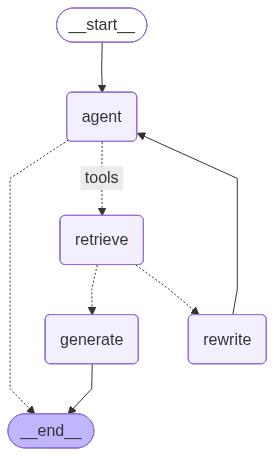

In [ ]:
# Define a new graph
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite) 
workflow.add_node("generate", generate)  

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [112]:
graph.invoke({"messages":"نوت میانی عطر چقدر ماندگاری دارد"})

---CALL AGENT---
messages = state[messages] : [HumanMessage(content='نوت میانی عطر چقدر ماندگاری دارد', additional_kwargs={}, response_metadata={}, id='979ee9aa-eaee-41bb-8812-8819eeb6989c')]

response = model.invoke(messages) : content='' additional_kwargs={'reasoning_content': 'The user writes in Persian: "نوت میانی عطر چقدر ماندگاری دارد" which translates to "How long does the middle note of perfume last?" They are asking about perfume longevity of middle notes. We should answer in Persian. We may use the perfume knowledge base. We\'ll search for "middle note longevity" or "مدت زمان ماندگاری نوت میانی عطر" in the perfume_vector_db.', 'tool_calls': [{'id': 'fc_5237126f-92e3-42ce-aa97-0487d0fb58dc', 'function': {'arguments': '{"query":"مدت زمان ماندگاری نوت میانی عطر"}', 'name': 'perfume_vector_db'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 254, 'total_tokens': 384, 'completion_time': 0.133908801, 'completion_tokens_details': 

{'messages': [HumanMessage(content='نوت میانی عطر چقدر ماندگاری دارد', additional_kwargs={}, response_metadata={}, id='979ee9aa-eaee-41bb-8812-8819eeb6989c'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user writes in Persian: "نوت میانی عطر چقدر ماندگاری دارد" which translates to "How long does the middle note of perfume last?" They are asking about perfume longevity of middle notes. We should answer in Persian. We may use the perfume knowledge base. We\'ll search for "middle note longevity" or "مدت زمان ماندگاری نوت میانی عطر" in the perfume_vector_db.', 'tool_calls': [{'id': 'fc_5237126f-92e3-42ce-aa97-0487d0fb58dc', 'function': {'arguments': '{"query":"مدت زمان ماندگاری نوت میانی عطر"}', 'name': 'perfume_vector_db'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 254, 'total_tokens': 384, 'completion_time': 0.133908801, 'completion_tokens_details': {'reasoning_tokens': 90}, 'prompt_time': 0.01238128, 'pr

# model always rely on itself not context or retriever try to fix it
problem was:

- bad description fails in retriever toolNode
- bad model chosen for llm
- english persion mix traslation
- **next time try to use documents and messages state seperatly not in annotated sequence messages**

In [41]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]